# CanOpenness Demo Script

This is a Jupyter Notebook for users to use which demonstrates the workflow for using the CanOpenness package to calculate canopy openness from hemispheric photos. 

## This script
**What this script currently does**  
Currently this script tests functions to then be incorporated into the classes in the CanOpenness package

**What this will eventually do**  
walk through the different functions in the CanOpeness package and help the user:
  - 1) Upload image files from the TestPhotos folder that comes with the package  
  - 2) Normalize the exposure across multiple photos to get consistent estimates  
  - 3) Choose the blue channel from RGB data in the photo to display as black and white  
  - 4) Segement the photo so that white = sky and black = canopy, and calculate area of sky in photo  
  - 5) Save the resultant calculations and output in a dataframe
 

In [291]:
#Upload pacakges (currently just dependencies)
import skimage #image manipulation
from skimage import io
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu #threshold algorithm
import pathlib #getting pathfiles
import pandas #dataframe manipulation and outputting
import numpy as np #statistical calculations
import glob #helping identify files in pathfiles
import os #finding pathfiles
import natsort #batch loading of files
import matplotlib.pyplot as plt #plots

### First testing out functions to load images and then display them
Starting with one photo, then will try in batch mode

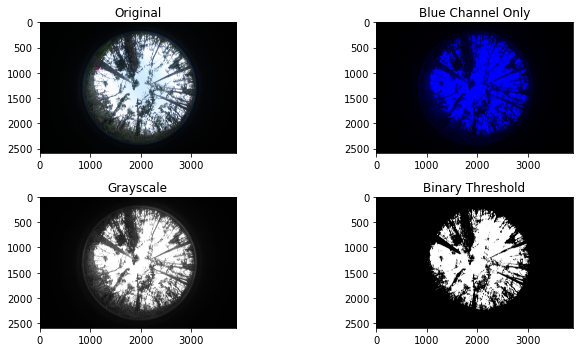

In [254]:
#image path file
filepath = ("/home/roiak/hacks/Canopy-Openness-from-Hemispheric-Photos/Sample Photos/")
#uploading sample photo
filename = os.path.join(filepath,'Sample_Photo.JPG')
#reading image file using io.imread from skimage
photo = io.imread(filename)

#converting photo to just blue channel
photo_blue = photo.copy() #copying original photo
#setting only blue channel by setting R and G (0 and 1 indexed in numpy array of image file) to 0 
photo_blue[:,:,0] = 0
photo_blue[:,:,1] = 0

#converting photo to grayscale
photo_gray = rgb2gray(photo_blue)

#converting to black and white by thresholding

#set threshold based on otsu algorithm (if above threshold, array set to 1, otherwise 0 creating black-and-white)
th = threshold_otsu(photo_gray)

#Create new image 
binary = photo_gray > th

#plotting all together
fig, axes = plt.subplots(2, 2, figsize=(10,5)) #setting rows and columns
ax = axes.ravel()

ax[0].imshow(photo) #first image 
ax[0].set_title("Original") #title
ax[1].imshow(photo_blue) #blue channel
ax[1].set_title("Blue Channel Only") #title
ax[2].imshow(photo_gray, cmap="gray") #grayscale
ax[2].set_title("Grayscale") #title
ax[3].imshow(binary, cmap=plt.cm.gray) #black and white after threshold
ax[3].set_title("Binary Threshold") #title

#output
fig.tight_layout() #layout tight
plt.show() #show plot

### Turning the above code into a class with functions
This will then be installable more easily for users

In [289]:
# #defining class of functions
# class ImagePrep():
#     """
#     Class object to load image files and convert them to black and white to differentiate sky from canopy objects
#     """
#     #some kind of function to intialize, still not sure how or what to do here
#     def __init__(self)

#function to load image and plot it    
def imageLoad(filepath, filename):
    """
    This function takes a filepath and filename of an image and loads that image and returns it and plots it
    
    PARAMETERS
    filepath - where image is stored (a directory)
    filename - name of image (with jpg, png ending)
    """
    #uploading photo based on given path and image name
    photo_location = os.path.join(filepath,filename)
        
    #reading image file using io.imread from skimage
    photo = io.imread(photo_location)
        
    #plot photo
    plt.imshow(photo)
    
    #return photo
    return photo

#function to convert image to blue channel
def BluePic(image = ""):
    """
    This function converts a loaded image into just the blue from RGB channel.
    Outputs image file with just blue channel and plots it
    
    PARAMETERS
    input - image file
    """
    
    #setting only blue channel by setting R and G (0 and 1 indexed in numpy array of image file) to 0 
    image[:,:,0] = 0
    image[:,:,1] = 0
    
    #plot photo
    plt.imshow(image)
        
    #return photo
    return image


#function to turn blue image into thresholded black and white image
def bwPic(image = ""):
    """
    This function takes an image file as input, converts to greyscale, uses an algorithm to threshold,
    and then converts the photo into binary black and white based on that threshold.
    Outputs a new binary image and plots it
    
    PARAMETERS
    Inputted image file
    """
    #converting photo to grayscale
    gray_image = rgb2gray(image)
    #set threshold based on otsu algorithm (if above threshold, array set to 1, otherwise 0 creating black-and-white)
    th = threshold_otsu(gray_image)
    
    #Create new image 
    binary = gray_image > th
    
    #plots image
    plt.imshow(binary,cmap=plt.cm.gray)
    
    #returns it
    return binary

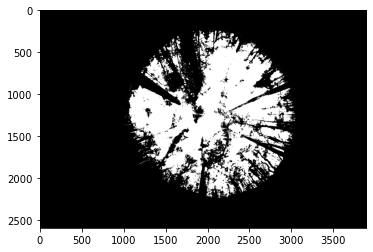

In [290]:
#Testing functions above
photo=imageLoad(filepath,filename) #plots original image nice!

blue_photo=BluePic(photo) #plots blue image nice!

bw_photo=bwPic(blue_photo) #plots black and white image nice!

### Now detecting edges
We want to segment only the edges of the circle of the fisheye lens so our calculations are accurate

In [242]:
#Adding center coordinates of image and radius of center
def CircleCoords(image = ""):
    """
    Function that takes an image as input and returns image file with circle of fisheye lens as boundary
    Based on calculating of center coordinates given the shape of the numpy array (file format of image)
    
    PARAMETERS
    image = input loaded image
    
    OUTPUT
    returns image array with coordinates for center circle of fisheye photo
    """
    
    #x coordinate of center
    fish_cx = image.shape[1]/2
    #y coordinate of center
    fish_cy = image.shape[0]/2
    #radius of the hemispheric photo center
    fish_cr = (image.shape[0]/2)-2
    
    #put all those in a list with new coordinates
    ImageCircle = [image,fish_cx,fish_cy,fish_cr]
    
    #return new format of image
    return ImageCircle

#Testing out function
hemi_photo = CircleCoords(photo) #on original photo
#hemi_photo[1] #works! 
hemi_th = CircleCoords(binary) #on black and white threshold
#-----------------------------------------------------------


#Setting circle based on the calculated center circle radius (not sure if we need this, it's mostly for plotting)
def SetCircle(image = "", cx=0,cy=0,cr=0):
    """
    Function that sets image coordinates based on previous calculations of center circle of hemispheric image
    
    PARAMETERS
    image = image after it's gone through Image2Circle function
    cx = center x coordinate
    cy = center y coordinate
    cr = radius of center circle of fisheye lens
    """
    #if coordinates greater than 0, set them as center circle coordinates for image file
    if(cx>0):
        image[1] = cx
    if(cy>0):
        image[2] = cy
    if(cr>0):
        image[3] = cr
    
    #output image array
    return(image)

#Testing out function
circle_test = SetCircle(hemi_photo)
#circle_test[1] #works!    

#-----------------------------------------------------------

# #Draw circle on photo to visualize (still not working)
# def DrawCircle(image="",cx=100, cy=100, cr=50):
#     """
#     Function to draw circle around fisheye photo 
    
#     PARAMETERS
#     center coordinates and radius of circle
#     Inputted image
#     """
#     #setting radius
#     cr = int(image[3])
#     #setting range for x from 0 to radius based on indexing from image object
#     x = list(range(0,cr))
#     #Dividing by list
#     list_divide = [i / cr for i in x]
#     #calculating y 
#     y = numpy.sin(np.arccos(list_divide))*cr
# 
#     #Here I need to plot points of circle based on the above calculate new arrays
#     points(cx + x, cy + y, col = "red", cex = 0.1)
#     points(cx + x, cy - y, col = "red", cex = 0.1)
#     points(cx - x, cy + y, col = "red", cex = 0.1)
#     points(cx - x, cy - y, col = "red", cex = 0.1)
#     y = x
#     x = cos(asin(x/radius)) * radius
#     points(cx + x, cy + y, col = "red", cex = 0.1)
#     points(cx + x, cy - y, col = "red", cex = 0.1)
#     points(cx - x, cy + y, col = "red", cex = 0.1)
#     points(cx - x, cy - y, col = "red", cex = 0.1)

### Now we create a class to calculate the gap fraction and openness in the image
We will use the coordinates for the fisheye lens circle we got above.
Our first function will iterate through 89 smaller circles within those and get the amount of white in each one.
Then we will divide those by 360 degrees to get a fraction of the circle.

Our second function will iterate through those fraction calculations, sum them up and divide by the whole picture area to get one openness (from 0 to 1) value for the entire image.

In [251]:
# #defining function to calculate gap fraction (this still doesn't work because I'm having trouble multiplying by sequences)
# def GapFractions(image = ""):
#     """
#     This function calculates gap fraction (fraction sky) for an image file that's been converted to black and white already
    
#     PARAMETERS
#     Takes the image file as input
    
#     Gets coordinates for fisheye circle from previous function CircleCoords
#     Converts degrees to radians 
#     Sets an empty matrix for 89 mini-circles within image
    
#     Iterates over those and calculates amount that is set to 0 (i.e. white or sky) in image
#     Within each circle iterates over 360 degrees and fills matrix with the value for that circle
    
#     Then normalizes each circle's score by dividing by 360.
#     Returns the array of 89 circles with each having a unique value of fraction sky
    
#     """
#     #getting radians
#     radian = math.pi /180
#     #setting empty matrix for all 89 circles
#     gfp = np.zeros((1,89))
#     #counting steps
#     steps = np.asarray(list(range(1,360)))
#     #setting coordinates for fisheye lens circle
#     cx = int(hemi_th[1]) #x
#     cy = int(hemi_th[2]) #y
#     cr = int(hemi_th[3]) #radius

#     #iterating through circles to calculate gap fraction
#     for i in len(range(1,89)):
#         x = round(cx + math.cos(steps*radian)*i*cr/90,0) #set x array
#         y = round(cy + sin(steps*deg2rad)*i*cr/90,0) #set y array
#         #now iterate over 360 degrees
#         for j in len(range(1,360)):
#             gfp[i] = gfp[i] + image[0][y[j],x[j]] #add values of gap fractions

#     #return gfp normalized by 360 degrees (so returns fraction 0-1)    
#     return gfp/360 


#defining function to calculate openness (still not working)
# def Openness(gfp):
#     """
#     This function takes input from gap fraction calculation above and sums it, then normalizes over area of entire image
#     This yields one value for an image about the fraction (0-1) of sky open in that hemispheric photo
    
#     PARAMETERS
#     Array of gap fraction calculations from the GapFractions function
#     """
#     #getting radians
#     radian = math.pi / 180
#     #Half a radian
#     half_rad = radian * 0.5
#     #angle for each circle (same issue here with multiplying by a sequence)
#     ang = radian * np.asarray(list(range(1,89)))
#     #Total area of hemispheric photo
#     Total_area = math.sin(ang[89] + half_rad) - math.sin(ang[1] - half_rad)
#     #Area for each circle
#     Circ_areas = math.sin(ang + half_rad) - math.sin(ang - half_rad)
    
#     #Calculating openness by summing fractions times area of each circle divided by total area of image
#     CanOpen = sum(gfp*Circ_areas/Total_area)
    
#     #Return CanOpen value
#     return CanOpen